# Quality control routines for PNBOIA

In [1]:
import pandas as pd
%load_ext autoreload
%autoreload 2
import pnboia_qc.pnboia_limits as pnboia_limits
from pnboia_qc.qc_checks import QCChecks


# conexao banco
from dotenv import load_dotenv
import pandas.io.sql as sqlio
import psycopg2
import os

load_dotenv()


True

## Load PNBOIA data

In [2]:
df = pd.read_excel('../raw_data/po.xlsx')

FileNotFoundError: [Errno 2] No such file or directory: '../raw_data/po.xlsx'

In [3]:
df.head()

,#ano,mes,dia,hora,lon,lat,battery,wspd1,gust1,wdir1,...,cdir1,cvel2,cdir2,cvel3,cdir3,wvht,wmax,dpd,mwd,spred
0,2012,7,6,4,-37.945000,-15.989500,12.2,7.6,9.2,132.0,...,175.25,99.91,177.81,97.79,183.18,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
1,2012,7,6,5,-37.945667,-15.988833,12.2,7.4,9.1,122.0,...,189.33,84.58,186.64,97.82,169.48,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
2,2012,7,6,6,-37.945833,-15.987833,12.2,6.2,7.9,127.0,...,325.59,43.52,324.20,43.96,344.74,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
3,2012,7,6,7,-37.945833,-15.988333,12.2,6.8,8.5,112.0,...,270.37,27.47,268.81,28.30,208.79,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
4,2012,7,6,8,-37.945500,-15.989000,12.2,7.6,9.8,116.0,...,212.59,81.56,202.39,78.75,238.80,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0


In [3]:
# H
# nao achei o arquivo po.xlsx, mas parece ser um raw de uma axys historica. O resultado final é um dataframe parseado nos campos de interesse.
# variables vai receber os nomes desses campos de interesse.

## Create DateTime column

In [4]:
df['date_time'] = df['#ano'].astype(str).str.zfill(4) + df['mes'].astype(str).str.zfill(2) + df['dia'].astype(str).str.zfill(2) + df['hora'].astype(str).str.zfill(2)

In [5]:
df['date_time'] = pd.to_datetime(df['date_time'], format='%Y%m%d%H')
df.set_index('date_time', inplace=True)

In [6]:
df.drop(columns=['#ano', 'mes', 'dia', 'hora'], inplace=True)

In [7]:
df.columns = ['lon', 'lat', 'battery', 'wspd1', 'gust1', 'wdir1', 'wspd2', 'gust2',
       'wdir2', 'atmp', 'rh', 'dewpt', 'pres', 'sst', 'compass', 'arad',
       'cspd1', 'cdir1', 'cspd2', 'cdir2', 'cspd3', 'cdir3', 'swvht', 'mxwvht',
       'tp', 'wvdir', 'spred']

In [8]:
df.head()

,lon,lat,battery,wspd1,gust1,wdir1,wspd2,gust2,wdir2,atmp,...,cdir1,cspd2,cdir2,cspd3,cdir3,swvht,mxwvht,tp,wvdir,spred
date_time,,,,,,,,,,,,,,,,,,,,,
2012-07-06 04:00:00,-37.945000,-15.989500,12.2,7.6,9.2,132.0,7.4,9.1,130.0,24.9,...,175.25,99.91,177.81,97.79,183.18,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
2012-07-06 05:00:00,-37.945667,-15.988833,12.2,7.4,9.1,122.0,7.2,8.9,120.0,24.5,...,189.33,84.58,186.64,97.82,169.48,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
2012-07-06 06:00:00,-37.945833,-15.987833,12.2,6.2,7.9,127.0,6.1,7.7,125.0,24.3,...,325.59,43.52,324.20,43.96,344.74,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
2012-07-06 07:00:00,-37.945833,-15.988333,12.2,6.8,8.5,112.0,6.6,8.4,111.0,24.9,...,270.37,27.47,268.81,28.30,208.79,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
2012-07-06 08:00:00,-37.945500,-15.989000,12.2,7.6,9.8,116.0,7.4,9.6,114.0,25.0,...,212.59,81.56,202.39,78.75,238.80,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0


In [9]:
variables = df.drop(columns=['lon', 'lat', 'battery']).columns.to_list()

In [117]:
# H
# obtendo um dado general analogo de uma axys_general_new pra testar e adaptando pra ficar parecido ao po.xlsx

df = pd.read_csv('../itaguai_gen_100.csv',index_col='date_time')

#eventualmente podemos usar o extractor nesse passo

In [2]:
def extractor(id, table='qualified_data.qualified_data'):
    # Connect to your postgres DB
    conn = psycopg2.connect(f"dbname={os.getenv('DB_NAME')} \
                            user={os.getenv('DB_USER')} \
                            password={os.getenv('DB_PASSWORD')} \
                            host={os.getenv('DB_HOST')}")

    query = f"SELECT * FROM {table} WHERE buoy_id = {id}"

    query += " ORDER BY date_time"
    
    df = sqlio.read_sql(query, conn)
    conn.close()

    return df

df = extractor(8,table='moored.axys_general_new')
df.set_index('date_time',inplace=True)

/tmp/ipykernel_15672/3518382277.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = sqlio.read_sql(query, conn)


In [3]:
df.dropna(axis=1,how='all',inplace=True) #retirando as colunas vazias
df.head()

,id,buoy_id,latitude,longitude,geom,battery,compass,wspd1,wdir1,gust1,...,cdir1,cspd2,cdir2,cspd3,cdir3,swvht1,tp1,wvdir1,mxwvht1,wvspread1
date_time,,,,,,,,,,,,,,,,,,,,,
2019-09-20 19:00:00,297298,8,-23.47704,-43.98186,0101000020E610000012A0A696ADFD45C043E21E4B1F7A...,13.7,234.0,5.0,216.0,6.0,...,326.0,0.051,286.0,0.065,345.0,1.64,11.1,177.0,2.60,39.0
2019-09-20 20:00:00,297300,8,-23.47630,-43.98417,0101000020E610000027DA5548F9FD45C0B515FBCBEE79...,13.1,222.0,4.0,204.0,5.0,...,331.0,0.040,302.0,0.065,345.0,1.61,8.3,156.0,2.48,42.0
2019-09-20 21:00:00,297301,8,-23.47615,-43.97958,0101000020E610000068E89FE062FD45C08BFD65F7E479...,12.8,222.0,1.0,204.0,3.0,...,316.0,0.025,244.0,0.029,335.0,1.51,9.1,156.0,2.32,45.0
2019-09-20 22:00:00,297302,8,-23.47624,-43.98348,0101000020E6100000922232ACE2FD45C00B0C59DDEA79...,12.8,207.0,0.0,189.0,0.0,...,231.0,0.085,173.0,0.062,183.0,1.51,12.5,162.0,2.15,42.0
2019-09-20 23:00:00,297304,8,-23.47727,-43.98259,0101000020E610000036B05582C5FD45C0A75CE15D2E7A...,12.7,186.0,0.0,147.0,2.0,...,197.0,0.154,169.0,0.110,161.0,1.52,12.5,159.0,2.40,39.0


In [4]:
# adaptando o variable
variables = df.drop(columns=['id','buoy_id','geom','compass','longitude', 'latitude', 'battery']).columns.to_list()
variables

['wspd1',
 'wdir1',
 'gust1',
 'wspd2',
 'wdir2',
 'gust2',
 'atmp',
 'srad',
 'rh',
 'dewpt',
 'pres',
 'sst',
 'cspd1',
 'cdir1',
 'cspd2',
 'cdir2',
 'cspd3',
 'cdir3',
 'swvht1',
 'tp1',
 'wvdir1',
 'mxwvht1',
 'wvspread1']

## Open limits for the data

In [216]:
mis_values = pnboia_limits.mis_value_axys_limits
limits = pnboia_limits.range_axys_limits
fine_limits = pnboia_limits.fine_axys_limits
stuck_limit = pnboia_limits.stuck_axys_limits
sigma_values = pnboia_limits.sigma_axys_limits
height = pnboia_limits.height
continuity_limit = pnboia_limits.continuity_axys_limits
anem_limits = pnboia_limits.anemometer_ascat

In [217]:
sigma_values

{'swvht': 6,
 'rh': 20,
 'pres': 21,
 'atmp': 11,
 'wspd': 25,
 'wspd1': 25,
 'wspd2': 25,
 'sst': 8.6}

In [5]:
# H
# O pnboia_limits tem um qc_config artificial. Em teoria a gente puxa direto do banco ne?
def extractor_qc(id, table='qualified_data.qualified_data'):
    # Connect to your postgres DB
    conn = psycopg2.connect(f"dbname={os.getenv('DB_NAME_LOCAL')} \
                            user={os.getenv('DB_USER')} \
                            password={os.getenv('DB_PASSWORD')} \
                            host=localhost")

    query = f"SELECT * FROM {table} WHERE buoy_id = {id}"

    df = sqlio.read_sql(query, conn)
    conn.close()

    return df

qc = extractor_qc(9,table='quality_control.general')
qc_config = qc.qc_config[0]

/tmp/ipykernel_15672/1927381705.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = sqlio.read_sql(query, conn)


In [6]:
# para transformar o qc_config do banco nos equivalentes ao do pnboia_limits
mis_values = {}
limits = {}
fine_limits = {}
stuck_limit = qc_config['stuck_sensor']['limits']
sigma_values = {}
height = qc_config['convert_wind']['height']
continuity_limit = qc_config['t_continuity']['limits']
# anem_limits = ???

In [7]:
for param, limit in zip(qc_config['miss_value']['parameters'], qc_config['miss_value']['limits']):
    mis_values[param] = limit

for param, limit in zip(qc_config['gross_range']['parameters'], qc_config['gross_range']['limits']):
    limits[param] = limit

for param, limit in zip(qc_config['fine_range']['parameters'], qc_config['fine_range']['limits']):
    fine_limits[param] = limit

for param, limit in zip(qc_config['t_continuity']['parameters'], qc_config['t_continuity']['sigma']):
    sigma_values[param] = limit

## Create the class to start the qc tests

In [8]:
qc = QCChecks(data=df,
              variables=variables,
              mis_values=mis_values,
              limits=limits,
              fine_limits=fine_limits,
              stuck_limit=stuck_limit,
              sigma_values=sigma_values,
              continuity_limit=continuity_limit,
              height=height
             )

In [132]:
help(qc)

Help on QCChecks in module pnboia_qc.qc_checks object:

class QCChecks(builtins.object)
 |  QCChecks(data: pandas.core.frame.DataFrame, variables: list, mis_values: dict = None, limits: dict = None, fine_limits: dict = None, stuck_limit: int = None, sigma_values: dict = None, continuity_limit: int = None, height: dict = None, qc_config: dict = None)
 |  
 |  Class that contains all the quality control process.
 |  
 |  Variables:
 |  data:pd.DataFrame -> dataframe that has an index as datetime and variables in each column,
 |  variables:list -> list of variables that represents the data that will be QC. Ex.: ['wspd', 'tp']
 |  mis_values:dict=None -> dictionary for missing values for each variable. Ex: {'wspd': [-9999, np.nan], 'tp': [-9999]}
 |  limits:dict=None -> dictionary for sensors limits. If the sst sensor collect data between 0-40°C, the limits will {'sst': [0, 39]}
 |  fine_limits:dict=None -> dictionary for outlier limit.
 |  stuck_limit:int=None -> number of allowed repitit

## Misvalue test

In [9]:
for parameter in mis_values.keys():
    qc.mis_value(parameter=parameter)

No mis_value_limit for wspd1
wspd1: 0 flagged data
No mis_value_limit for gust1
gust1: 0 flagged data
No mis_value_limit for wdir1
wdir1: 0 flagged data
No mis_value_limit for wspd2
wspd2: 0 flagged data
No mis_value_limit for gust2
gust2: 0 flagged data
No mis_value_limit for wdir2
wdir2: 0 flagged data
No mis_value_limit for atmp
atmp: 0 flagged data
No mis_value_limit for rh
rh: 0 flagged data
No mis_value_limit for dewpt
dewpt: 0 flagged data
No mis_value_limit for pres
pres: 0 flagged data
No mis_value_limit for sst
sst: 0 flagged data
No mis_value_limit for srad
srad: 0 flagged data
No mis_value_limit for cspd1
cspd1: 0 flagged data
No mis_value_limit for cdir1
cdir1: 0 flagged data
No mis_value_limit for cspd2
cspd2: 0 flagged data
No mis_value_limit for cdir2
cdir2: 0 flagged data
No mis_value_limit for cspd3
cspd3: 0 flagged data
No mis_value_limit for cdir3
cdir3: 0 flagged data
No mis_value_limit for swvht1
swvht1: 0 flagged data
No mis_value_limit for tp1
tp1: 0 flagged dat

In [10]:
mis_values


{'wspd1': [-9999, None],
 'gust1': [-9999, None],
 'wdir1': [-9999, None],
 'wspd2': [-9999, None],
 'gust2': [-9999, None],
 'wdir2': [-9999, None],
 'atmp': [-9999, None],
 'rh': [-9999, None],
 'dewpt': [-9999, None],
 'pres': [-9999, None],
 'sst': [-9999, None],
 'srad': [-9999, None],
 'cspd1': [-9999, None],
 'cdir1': [-9999, None],
 'cspd2': [-9999, None],
 'cdir2': [-9999, None],
 'cspd3': [-9999, None],
 'cdir3': [-9999, None],
 'swvht1': [-9999, None],
 'tp1': [-9999, None],
 'mxwvht1': [-9999, None],
 'wvdir1': [-9999, None],
 'wvspread1': [-9999, None]}

In [11]:
# qc.flag.wvdir
qc.flag.wvdir1

date_time
2019-09-20 19:00:00    0
2019-09-20 20:00:00    0
2019-09-20 21:00:00    0
2019-09-20 22:00:00    0
2019-09-20 23:00:00    0
                      ..
2020-01-07 01:00:00    0
2020-01-07 02:00:00    0
2020-01-07 03:00:00    0
2020-01-07 05:00:00    0
2020-01-07 18:00:00    0
Name: wvdir1, Length: 2012, dtype: int64

## Range test

In [12]:
for parameter in limits.keys():
    qc.range(parameter=parameter, test='gross')
    qc.range(parameter=parameter, test='fine')

rh: 7 flagged data
rh: 0 flagged data
wspd1: 349 flagged data
wspd1: 0 flagged data
wdir1: 1 flagged data
No range_limit for wdir1
wspd2: 4 flagged data
wspd2: 0 flagged data
wdir2: 4 flagged data
No range_limit for wdir2
gust1: 200 flagged data
gust1: 0 flagged data
gust2: 0 flagged data
gust2: 0 flagged data
atmp: 0 flagged data
atmp: 0 flagged data
pres: 9 flagged data
pres: 11 flagged data
dewpt: 2 flagged data
dewpt: 0 flagged data
sst: 4 flagged data
sst: 0 flagged data
cspd1: 0 flagged data
cspd1: 12 flagged data
cdir1: 17 flagged data
No range_limit for cdir1
cspd2: 0 flagged data
cspd2: 17 flagged data
cdir2: 16 flagged data
No range_limit for cdir2
cspd3: 0 flagged data
cspd3: 17 flagged data
cdir3: 15 flagged data
No range_limit for cdir3
swvht1: 4 flagged data
swvht1: 7 flagged data
tp1: 2 flagged data
tp1: 11 flagged data
mxwvht1: 2 flagged data
mxwvht1: 1 flagged data
wvdir1: 2 flagged data
No range_limit for wvdir1
wvspread1: 5 flagged data
No range_limit for wvspread1


## Comparison between ascat and anemometers


In [13]:
qc.ascat_anemometer(limits=anem_limits['portoseguro'])

NameError: name 'anem_limits' is not defined

## Comparison between swvht and mxwvht

In [14]:
qc.swvht_mxwvht(swvht_name = 'swvht1', mxwvht_name = 'mxwvht1')

swvht1: 18 flagged data
mxwvht1: 22 flagged data


## Comparison of wind speed and gust

In [15]:
qc.wind_speed_gust(wspd_name='wspd1', gust_name='gust1')
qc.wind_speed_gust(wspd_name='wspd2', gust_name='gust2')

wspd1: 17 flagged data
gust1: 16 flagged data
wspd2: 13 flagged data
gust2: 13 flagged data


## Comparison of Dewpt and Atmp

In [16]:
qc.dewpt_atmp(dewpt_name='dewpt', atmp_name='atmp')

dewpt: 406 flagged data


## Comparison of battery and pressure

In [17]:
qc.battery(battery_name='battery', pres_name='pres')

pres: 6 flagged data


## Stuck sensor test

In [18]:
for parameter in variables:
    if parameter != 'battery':
        qc.stuck_sensor(parameter=parameter)

wspd1: 144 flagged data
wdir1: 32 flagged data
gust1: 139 flagged data
wspd2: 176 flagged data
wdir2: 26 flagged data
gust2: 130 flagged data
atmp: 5 flagged data
srad: 0 flagged data
rh: 1022 flagged data
dewpt: 9 flagged data
pres: 61 flagged data
sst: 1 flagged data
cspd1: 0 flagged data
cdir1: 0 flagged data
cspd2: 0 flagged data
cdir2: 1 flagged data
cspd3: 1 flagged data
cdir3: 1 flagged data
swvht1: 0 flagged data
tp1: 18 flagged data
wvdir1: 4 flagged data
mxwvht1: 0 flagged data
wvspread1: 39 flagged data


/home/user/virtual_envs/env_pnboia_qc/lib/python3.11/site-packages/pnboia_qc/qc_checks.py:330: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  value = value.rolling(f'{stuck_limit}H').sum()
/home/user/virtual_envs/env_pnboia_qc/lib/python3.11/site-packages/pnboia_qc/qc_checks.py:330: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  value = value.rolling(f'{stuck_limit}H').sum()
/home/user/virtual_envs/env_pnboia_qc/lib/python3.11/site-packages/pnboia_qc/qc_checks.py:330: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  value = value.rolling(f'{stuck_limit}H').sum()
/home/user/virtual_envs/env_pnboia_qc/lib/python3.11/site-packages/pnboia_qc/qc_checks.py:330: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  value = value.rolling(f'{stuck_limit}H').sum()
/home/user/virtual_envs/env_pnbo

## Convert wind to 10 meters

In [19]:
qc.convert_wind(wspd_name='wspd1', gust_name='gust1', height=4.7)
qc.convert_wind(wspd_name='wspd2', gust_name='gust2', height=3.4)

## Select the best anemometer

In [20]:
qc.best_sensor(parameters1=['wspd1', 'wdir1', 'gust1'],parameters2=['wspd2','wdir2', 'gust2'])

## Time continuity test

In [21]:
for parameter in sigma_values.keys():
    try:
        qc.t_continuity(parameter=parameter)
    except:
        print('error')

/home/user/virtual_envs/env_pnboia_qc/lib/python3.11/site-packages/pnboia_qc/qc_checks.py:475: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forward_values = np.array(value - value[0])
/home/user/virtual_envs/env_pnboia_qc/lib/python3.11/site-packages/pnboia_qc/qc_checks.py:476: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  backward_values = np.array(value - value[-1])
/home/user/virtual_envs/env_pnboia_qc/lib/python3.11/site-packages/pnboia_qc/qc_checks.py:475: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent wi

wspd1: 8 flagged data


/home/user/virtual_envs/env_pnboia_qc/lib/python3.11/site-packages/pnboia_qc/qc_checks.py:475: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forward_values = np.array(value - value[0])
/home/user/virtual_envs/env_pnboia_qc/lib/python3.11/site-packages/pnboia_qc/qc_checks.py:476: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  backward_values = np.array(value - value[-1])
/home/user/virtual_envs/env_pnboia_qc/lib/python3.11/site-packages/pnboia_qc/qc_checks.py:475: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent wi

wspd2: 10 flagged data


/home/user/virtual_envs/env_pnboia_qc/lib/python3.11/site-packages/pnboia_qc/qc_checks.py:475: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forward_values = np.array(value - value[0])
/home/user/virtual_envs/env_pnboia_qc/lib/python3.11/site-packages/pnboia_qc/qc_checks.py:476: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  backward_values = np.array(value - value[-1])
/home/user/virtual_envs/env_pnboia_qc/lib/python3.11/site-packages/pnboia_qc/qc_checks.py:475: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent wi

atmp: 41 flagged data


/home/user/virtual_envs/env_pnboia_qc/lib/python3.11/site-packages/pnboia_qc/qc_checks.py:475: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forward_values = np.array(value - value[0])
/home/user/virtual_envs/env_pnboia_qc/lib/python3.11/site-packages/pnboia_qc/qc_checks.py:476: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  backward_values = np.array(value - value[-1])
/home/user/virtual_envs/env_pnboia_qc/lib/python3.11/site-packages/pnboia_qc/qc_checks.py:475: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent wi

rh: 32 flagged data


/home/user/virtual_envs/env_pnboia_qc/lib/python3.11/site-packages/pnboia_qc/qc_checks.py:475: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forward_values = np.array(value - value[0])
/home/user/virtual_envs/env_pnboia_qc/lib/python3.11/site-packages/pnboia_qc/qc_checks.py:476: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  backward_values = np.array(value - value[-1])
/home/user/virtual_envs/env_pnboia_qc/lib/python3.11/site-packages/pnboia_qc/qc_checks.py:475: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent wi

pres: 19 flagged data


/home/user/virtual_envs/env_pnboia_qc/lib/python3.11/site-packages/pnboia_qc/qc_checks.py:475: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forward_values = np.array(value - value[0])
/home/user/virtual_envs/env_pnboia_qc/lib/python3.11/site-packages/pnboia_qc/qc_checks.py:476: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  backward_values = np.array(value - value[-1])
/home/user/virtual_envs/env_pnboia_qc/lib/python3.11/site-packages/pnboia_qc/qc_checks.py:475: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent wi

sst: 70 flagged data


/home/user/virtual_envs/env_pnboia_qc/lib/python3.11/site-packages/pnboia_qc/qc_checks.py:475: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forward_values = np.array(value - value[0])
/home/user/virtual_envs/env_pnboia_qc/lib/python3.11/site-packages/pnboia_qc/qc_checks.py:476: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  backward_values = np.array(value - value[-1])
/home/user/virtual_envs/env_pnboia_qc/lib/python3.11/site-packages/pnboia_qc/qc_checks.py:475: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent wi

swvht1: 7 flagged data


## Front exception tests

In [22]:
qc.front_except1(wdir_name='wdir1', atmp_name='atmp')

atmp: 0 flagged data


In [23]:
qc.front_except3(wspd_name='wspd1', atmp_name='atmp')

atmp: 5 flagged data


In [25]:
qc.front_except4(pres_name='pres1', wspd_name='wspd1')

TypeError: unsupported operand type(s) for -: 'str' and 'str'

In [26]:
qc.front_except5(pres_name='pres')

TypeError: unsupported operand type(s) for -: 'str' and 'str'

In [27]:
qc.front_except6(wspd_name='wspd', swvht_name='swvht')

KeyError: 'swvht'

## Plots to compare data

In [28]:
df

,id,buoy_id,latitude,longitude,geom,battery,compass,wspd1,wdir1,gust1,...,cspd3,cdir3,swvht1,tp1,wvdir1,mxwvht1,wvspread1,wspd,wdir,gust
date_time,,,,,,,,,,,,,,,,,,,,,
2019-09-20 19:00:00,297298,8,-23.47704,-43.98186,0101000020E610000012A0A696ADFD45C043E21E4B1F7A...,13.7,234.0,5.43,216.0,6.52,...,0.065,345.0,1.64,11.1,177.0,2.60,39.0,5.43,216.0,6.52
2019-09-20 20:00:00,297300,8,-23.47630,-43.98417,0101000020E610000027DA5548F9FD45C0B515FBCBEE79...,13.1,222.0,4.35,204.0,5.43,...,0.065,345.0,1.61,8.3,156.0,2.48,42.0,4.35,204.0,5.43
2019-09-20 21:00:00,297301,8,-23.47615,-43.97958,0101000020E610000068E89FE062FD45C08BFD65F7E479...,12.8,222.0,1.09,204.0,3.26,...,0.029,335.0,1.51,9.1,156.0,2.32,45.0,1.09,204.0,3.26
2019-09-20 22:00:00,297302,8,-23.47624,-43.98348,0101000020E6100000922232ACE2FD45C00B0C59DDEA79...,12.8,207.0,0.00,189.0,0.00,...,0.062,183.0,1.51,12.5,162.0,2.15,42.0,1.13,189.0,2.25
2019-09-20 23:00:00,297304,8,-23.47727,-43.98259,0101000020E610000036B05582C5FD45C0A75CE15D2E7A...,12.7,186.0,0.00,147.0,2.17,...,0.110,161.0,1.52,12.5,159.0,2.40,39.0,2.25,147.0,2.17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-07 01:00:00,299446,8,-23.47721,-43.97910,0101000020E6100000BEC1172653FD45C0FC523F6F2A7A...,12.7,153.0,0.00,63.0,0.00,...,0.209,275.0,1.33,9.1,174.0,1.89,42.0,2.25,63.0,2.25
2020-01-07 02:00:00,299447,8,-23.47947,-43.97358,0101000020E61000001405FA449EFC45C0C269C18BBE7A...,12.7,147.0,1.09,63.0,3.26,...,0.211,280.0,1.34,9.5,162.0,2.24,42.0,1.09,63.0,3.26
2020-01-07 03:00:00,299448,8,-23.47803,-43.98076,0101000020E6100000CB9C2E8B89FD45C0C381902C607A...,12.7,NaN,1.09,63.0,3.26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.09,63.0,3.26


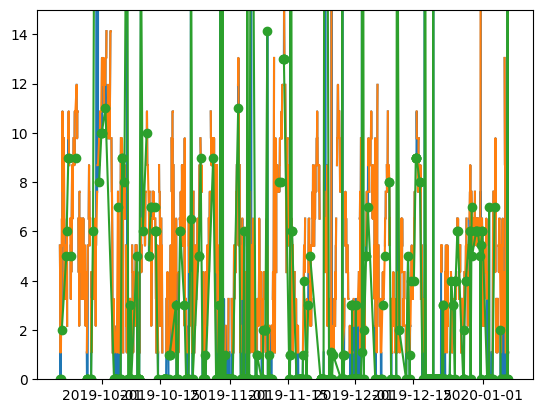

In [29]:
qc.plot_comparison(parameter='wspd1',ylim=[0,15], start_date='2016-01-01', end_date='2024-02-01')

In [30]:
qc.plot_comparison(parameter='wspd1',
                   ylim=[0,15],
                   start_date='2016-01-01',
                   end_date='2024-02-01',
                   plot_type='plotly')

In [31]:
mis_values.values()

dict_values([[-9999, None], [-9999, None], [-9999, None], [-9999, None], [-9999, None], [-9999, None], [-9999, None], [-9999, None], [-9999, None], [-9999, None], [-9999, None], [-9999, None], [-9999, None], [-9999, None], [-9999, None], [-9999, None], [-9999, None], [-9999, None], [-9999, None], [-9999, None], [-9999, None], [-9999, None], [-9999, None]])

In [11]:
anem_test = anem_limits['portoseguro']
qc_config = {
    'miss_value': {
        'parameters': list(mis_values.keys()),
        'limits': list(mis_values.values())
    },
    'gross_range': {
        'parameters': list(limits.keys()),
        'limits': list(limits.values())
    },
    'fine_range':{
        'parameters': list(fine_limits.keys()),
        'limits': list(fine_limits.values())
    },
    'ascat_anemometer':{
        'parameters': [['wspd1', 'wdir1', 'gust1'], ['wspd2','wdir2', 'gust2']],
        'limits': anem_test
    },
    'swvht_mxwvht': {
        'parameters': [['swvht', 'mxwvht']]
    },
    'wind_speed_gust': {
        'parameters': [['wspd1', 'gust1'], ['wspd2', 'gust2']]
    },
    'dewpt_atmp': {
        'parameters': [['dewpt', 'atmp']]
    },
    'battery': {
        'parameters': [['battery', 'pres']]
    },
    'stuck_sensor': {
        'parameters': variables, 'limits': stuck_limit},
    'convert_wind': {
        'parameters': [['wspd1', 'gust1'], ['wspd2', 'gust2']],
        'height': [4.7, 3.4]
    },
    'best_sensor': {
        'parameters': [['wspd1', 'wdir1', 'gust1'], ['wspd2','wdir2', 'gust2']]
    },
    # 't_continuity': {
    #     'parameters': list(sigma_values.keys()),
    #     'sigma': list(sigma_values.values()),
    #     'limits': continuity_limit,
    #     'exceptions': [
    #         {'test': 1,
    #          'parameters': ['wdir', 'atmp']},
    #         {'test': 3,
    #          'parameters': ['wspd', 'atmp']},
    #         {'test': 4,
    #          'parameters': ['pres', 'wspd']},
    #         {'test': 5,
    #          'parameters': 'pres'},
    #         {'test': 6,
    #          'parameters': ['wspd', 'swvht']}
    #     ]
    # },
    'true_north': {
        'parameters': ['wspd1', 'wspd2','cspd1','cdir1','cdir2','cdir3','wvdir'],
        'annual_variation': 0.05,
        'year_reference': 2010,
        'mag_deg': 10.07
    }
}

In [12]:
qc_config

{'miss_value': {'parameters': ['rh',
   'cspd1',
   'cdir1',
   'cspd2',
   'cdir2',
   'cspd3',
   'cdir3',
   'dewpt',
   'atmp',
   'sst',
   'swvht',
   'mxwvht',
   'tp',
   'wvdir',
   'spred'],
  'limits': [[11, -9999, nan],
   [409.5, -9999, nan],
   [511, -9999, nan],
   [409.5, -9999, nan],
   [511, -9999, nan],
   [409.5, -9999, nan],
   [511, -9999, nan],
   [-10, -9999, nan],
   [-10, -9999, nan],
   [40.955, -9999, nan],
   [20.47, -9999, nan],
   [20.47, -9999, nan],
   [25.5, -9999, nan],
   [381, -9999, nan],
   [381, -9999, nan]]},
 'gross_range': {'parameters': ['swvht',
   'mxwvht',
   'tp',
   'wvdir',
   'wspd1',
   'wdir1',
   'gust1',
   'wspd2',
   'wdir2',
   'gust2',
   'atmp',
   'pres',
   'dewpt',
   'sst',
   'rh',
   'cspd1',
   'cdir1',
   'cspd2',
   'cdir2',
   'cspd3',
   'cdir3'],
  'limits': [[0.1, 19.9],
   [0.1, 19.9],
   [1.7, 30],
   [0, 360],
   [0.1, 59],
   [0, 360],
   [0.1, 59],
   [0.1, 59],
   [0, 360],
   [0.1, 59],
   [-39, 59],
   [50

In [13]:
qc = QCChecks(data=df,
              variables=variables,
              qc_config=qc_config
             )

In [14]:
qc.run()

-------------
Check miss_value
parameter: rh
rh: 774 flagged data
parameter: cspd1
cspd1: 775 flagged data
parameter: cdir1
cdir1: 2505 flagged data
parameter: cspd2
cspd2: 774 flagged data
parameter: cdir2
cdir2: 2504 flagged data
parameter: cspd3
cspd3: 777 flagged data
parameter: cdir3
cdir3: 2502 flagged data
parameter: dewpt
dewpt: 775 flagged data
parameter: atmp
atmp: 774 flagged data
parameter: sst
sst: 2514 flagged data
parameter: swvht
swvht: 11120 flagged data
parameter: mxwvht
mxwvht: 11120 flagged data
parameter: tp
tp: 11116 flagged data
parameter: wvdir
wvdir: 11119 flagged data
parameter: spred
spred: 11116 flagged data
-------------
Check gross_range
parameter: swvht
swvht: 8 flagged data
parameter: mxwvht
mxwvht: 12 flagged data
parameter: tp
tp: 9 flagged data
parameter: wvdir
wvdir: 4 flagged data
parameter: wspd1
wspd1: 924 flagged data
parameter: wdir1
wdir1: 148 flagged data
parameter: gust1
gust1: 339 flagged data
parameter: wspd2
wspd2: 1969 flagged data
parame

In [15]:
qc.data

,lon,lat,battery,wspd1,gust1,wdir1,wspd2,gust2,wdir2,atmp,...,cspd3,cdir3,swvht,mxwvht,tp,wvdir,spred,wspd,wdir,gust
date_time,,,,,,,,,,,,,,,,,,,,,
2012-07-06 04:00:00,-37.945000,-15.989500,12.20,18.0,10.00,132.0,18.0,10.25,130.0,24.9,...,97.79,193.0,-9999.00,-9999.00,-9999.0,-9999.0,-9999.0,8.26,132.0,10.00
2012-07-06 05:00:00,-37.945667,-15.988833,12.20,18.0,9.89,122.0,18.0,10.02,120.0,24.5,...,97.82,179.0,-9999.00,-9999.00,-9999.0,-9999.0,-9999.0,8.04,122.0,9.89
2012-07-06 06:00:00,-37.945833,-15.987833,12.20,16.0,8.58,127.0,17.0,8.67,125.0,24.3,...,43.96,354.0,-9999.00,-9999.00,-9999.0,-9999.0,-9999.0,6.74,127.0,8.58
2012-07-06 07:00:00,-37.945833,-15.988333,12.20,17.0,9.24,112.0,17.0,9.46,111.0,24.9,...,28.30,218.0,-9999.00,-9999.00,-9999.0,-9999.0,-9999.0,7.39,112.0,9.24
2012-07-06 08:00:00,-37.945500,-15.989000,12.20,18.0,10.65,116.0,18.0,10.81,114.0,25.0,...,78.75,248.0,-9999.00,-9999.00,-9999.0,-9999.0,-9999.0,8.26,116.0,10.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-19 05:00:00,-37.938843,-16.002278,12.73,10.0,0.30,263.0,18.0,9.35,103.0,22.4,...,239.14,180.0,1.71,2.58,8.3,146.0,41.1,7.77,103.0,9.35
2016-12-19 06:00:00,-37.938917,-16.002095,12.70,10.0,0.60,276.0,16.0,8.11,106.0,22.7,...,130.70,165.0,1.64,2.62,8.7,153.0,40.5,6.42,106.0,8.11
2016-12-19 07:00:00,-37.938883,-16.002020,12.67,10.0,0.60,264.0,17.0,8.33,94.0,22.6,...,115.68,158.0,1.70,2.79,7.7,140.0,42.7,6.76,94.0,8.33
